# ToDo:
- try around with monotone scale
- implement + test monotone scale

# Insights:
- if order > 1, all entries matter (not only cubical)
- basis of log-scale is irrelevant

In [67]:
%load_ext autoreload
%autoreload 2

from jax.config import config
config.update("jax_enable_x64", True)

from jax.scipy.ndimage import map_coordinates
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np
from numpy.testing import assert_array_almost_equal as aaae
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator

import itertools
from lcm.interpolation import linear_interpolation
from lcm.grids import get_linspace_coordinate, get_logspace_coordinate, linspace, logspace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import jax.numpy as jnp
import lcm.grids as grids_module
from jax.scipy.ndimage import map_coordinates


def linear_interpolation(values, point, grid_info):
    """"""

    mapped_values = []
    for i, (grid_type, args) in enumerate(grid_info):
        func = getattr(grids_module, f"get_{grid_type}_coordinate")
        mapped_values.append(func(point[i], *args))

    mapped_point = jnp.array(mapped_values)

    res = map_coordinates(
        input=values, coordinates=mapped_point, order=1, mode="nearest"
    )

    return res

# Try different scales

## linspace

In [175]:
def test_linear_interpolation_2d():
    grid1 = np.array([1, 2, 3, 4, 5.0])
    grid2 = np.array([2, 3, 4.0])

    prod_grid = np.array(list(itertools.product(grid1, grid2)))
    values = (prod_grid ** 2).sum(axis=1).reshape(5, 3)

    points = np.array([[2.5, 3.5], [2.1, 3.8], [2.7, 3.3]])

    grid_info = [("linspace", (1, 5, 5)), ("linspace", (2, 4, 3))]

    for point in points:
        calculated = linear_interpolation(
            values=values,
            point=point,
            grid_info=grid_info,
        )

        scipy_func = RegularGridInterpolator(
            points=(grid1, grid2), values=values, method="linear"
        )
        scipy_res = scipy_func(point)

        aaae(calculated, scipy_res)

In [176]:
test_linear_interpolation_2d()

## logspace

In [148]:
def logspace(start, stop, n_points):
    start_exp = jnp.log(start)
    stop_exp = jnp.log(stop)
    return jnp.logspace(start_exp, stop_exp, n_points, base=2.718281828459045)

In [112]:
def get_linspace_coordinate(value, start, stop, n_points):
    """Map a value into the input needed for map_coordinates."""
    step_length = (stop - start) / (n_points - 1)
    mapped_point = (value - start) / step_length
    return mapped_point

In [188]:
def get_logspace_coordinate(value, start, stop, n_points):
    """Map a value into the input needed for map_coordinates."""
    step_factor = jnp.exp((jnp.log(stop) - jnp.log(start)) / (n_points - 1))
    mapped_point = jnp.log(value / start) / jnp.log(step_factor)
    return mapped_point

In [197]:
def get_logspace_coordinate1(value, start, stop, n_points):
    """Map a value into the input needed for map_coordinates."""
    step_factor = (jnp.log(stop) - jnp.log(start)) / (n_points - 1)
    mapped_point = (jnp.log(value) - jnp.log(start)) / step_factor
    return mapped_point

In [234]:
def get_logspace_coordinate2(value, start, stop, n_points):
    """Map a value into the input needed for map_coordinates."""
    start_exp = jnp.log(start)
    stop_exp = jnp.log(stop)
    value_exp = jnp.log(value)
    step_length = (stop_exp - start_exp) / (n_points - 1)
    mapped_point_log = (value_exp - start_exp) / step_length
    print(mapped_point_log)
    # Calculate mapped point on a linear scale
    lower_point = jnp.exp(start_exp + step_length * jnp.floor(mapped_point_log))
    upper_point = jnp.exp(start_exp + step_length * jnp.ceil(mapped_point_log))
    print(lower_point, upper_point)
    if lower_point == upper_point:
        mapped_point_lin = mapped_point_log
    else:
        mapped_point_lin = jnp.floor(mapped_point_log) + (value - lower_point) / (upper_point - lower_point)
    return mapped_point_lin


In [116]:
    grid1 = np.array([1, 10, 100.0])
    grid2 = np.array([1, 10, 100.0])

    prod_grid = np.array(list(itertools.product(grid1, grid2)))
    values = (prod_grid ** 2).sum(axis=1).reshape(3, 3)

    points = np.array([[1,1], [2.5, 3.5], [2.1, 3.8], [2.7, 3.3]])

    grid_info = [("linspace", (1, 5, 5)), ("linspace", (2, 4, 3))]

    for point in points:
        calculated = linear_interpolation(
            values=values, point=point, grid_info=grid_info,
        )

        scipy_func = RegularGridInterpolator(
            points=(grid1, grid2), values=values, method="linear"
        )
        scipy_res = scipy_func(point)
        print(calculated, scipy_res)
        aaae(calculated, scipy_res)

2.0 [2.]
10100.0 [46.]


AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 10054.
Max relative difference: 218.56521739
 x: array(10100.)
 y: array([46.])

In [112]:
grid1, grid2, values

(array([  1.,  10., 100.]),
 array([  1.,  10., 100.]),
 array([[2.0000e+00, 1.0100e+02, 1.0001e+04],
        [1.0100e+02, 2.0000e+02, 1.0100e+04],
        [1.0001e+04, 1.0100e+04, 2.0000e+04]]))

In [127]:
(101 +2) / 2

51.5

In [130]:
    grid1 = np.logspace(np.log10(1), np.log10(100), 3)
    grid2 = np.logspace(np.log10(1), np.log10(100), 3)

    prod_grid = np.array(list(itertools.product(grid1, grid2)))
    values = (prod_grid ** 2).sum(axis=1).reshape(3, 3)

    points = np.array([[5.5, 1], [10, 10], [9.8, 2.3], [2.1, 8.2], [2.7, 1.1]])

    grid_info = [("logspace", (1, 100, 3)), ("logspace", (1, 100, 3))]

    for point in points:
        calculated = linear_interpolation(
            values=values, point=point, grid_info=grid_info,
        )
        
        scipy_func = RegularGridInterpolator(
            points=(grid1, grid2), values=values, method="linear"
        )
        scipy_res = scipy_func(point)
        print(calculated, scipy_res)
        aaae(calculated, scipy_res)

51.499999999999986 [51.5]
200.0 [200.]
113.09999999999998 [113.1]
93.29999999999997 [93.3]
21.8 [21.8]


In [135]:
grid4

array([10., 11.])

In [144]:
def f(a, b, c):
    return 2 * a ** 3 + 3 * b ** 2 - c


def g(a, b, c, d):
    return f(a, b, c) - d

def h(a, b, c, d, e):
    return g(a, b, c, d) + e ** 5

grid1 = np.logspace(np.log10(1), np.log10(5), 5)
grid2 = np.logspace(np.log10(4), np.log10(7), 4)
grid3 = np.logspace(np.log10(7), np.log10(9), 2)
grid4 = np.logspace(np.log10(10), np.log10(11), 2)
grid5 = np.logspace(np.log10(3), np.log10(4), 10)

values = h(
    *np.meshgrid(grid1, grid2, grid3, grid4, grid5, indexing="ij", sparse=False)
)
print(grid1, grid2, grid3, grid4, grid5)
points = np.array(
    [[2.1, 6.2, 8.3, 10.4, 3], [5, 4.3, 7, 10.99999, 4], [3.3, 5.2, 7.1, 10, 3.6]]
)

grid_info = [
    ("logspace", (1, 5, 5)),
    ("logspace", (4, 7, 4)),
    ("logspace", (7, 9, 2)),
    ("logspace", (10, 11, 2)),
    ("logspace", (3, 4, 10)),
]

for point in points:
    print(point)
    calculated = linear_interpolation(
        values=values, point=point, grid_info=grid_info,
    )
    scipy_func = RegularGridInterpolator(
        points=(grid1, grid2, grid3, grid4, grid5), values=values, method="linear"
    )
    scipy_res = scipy_func(point)
    aaae(calculated, scipy_res)


[1.         1.49534878 2.23606798 3.34370152 5.        ] [4.         4.82028453 5.80878573 7.        ] [7. 9.] [10. 11.] [3.         3.0974431  3.19805124 3.30192725 3.40917725 3.51991085
 3.63424119 3.75228509 3.87416318 4.        ]
[ 2.1  6.2  8.3 10.4  3. ]
[ 5.       4.3      7.      10.99999  4.     ]
[ 3.3  5.2  7.1 10.   3.6]


In [76]:
    grid1 = np.logspace(np.log10(1), np.log10(100), 3)
    grid2 = np.logspace(np.log10(1), np.log10(100), 3)

    prod_grid = np.array(list(itertools.product(grid1, grid2)))
    values = (prod_grid ** 2).sum(axis=1).reshape(3, 3)

    points = np.array([[1, 1], [10, 10], [2.7, 1.1]])

    grid_info = [("logspace", (1, 100, 3)), ("logspace", (1, 100, 3))]

    for point in points:
        calculated = linear_interpolation(
            values=values, point=point, grid_info=grid_info,
        )

        scipy_func = RegularGridInterpolator(
            points=(grid1, grid2), values=values, method="linear"
        )
        scipy_res = scipy_func(point)
        print(point, calculated, scipy_res)
    print(grid1, grid2)
    print(values)

0.0 4.605170185988092 0.0
1 100 1.0
0.0
1.0 2.0
0.0 4.605170185988092 0.0
1 100 1.0
0.0
1.0 2.0
[1. 1.]
[1. 1.] 200.0 [2.]
0.0 4.605170185988092 2.302585092994046
1 100 10.0
1.0
10.000000000000002 11.000000000000002
0.0 4.605170185988092 2.302585092994046
1 100 10.0
1.0
10.000000000000002 11.000000000000002
[10. 10.]
[10. 10.] 20000.0 [200.]
0.0 4.605170185988092 0.9932517730102834
1 100 2.7
0.4313637641589873
1.0 2.0
0.0 4.605170185988092 0.09531017980432493
1 100 1.1
0.04139268515822507
1.0 2.0
[2.7 1.1]
[2.7 1.1] 11090.0 [21.8]
[  1.  10. 100.] [  1.  10. 100.]
[[2.0000e+00 1.0100e+02 1.0001e+04]
 [1.0100e+02 2.0000e+02 1.0100e+04]
 [1.0001e+04 1.0100e+04 2.0000e+04]]


In [48]:
logspace(1, 100, 7)

DeviceArray([  1.        ,   2.15443469,   4.64158883,  10.        ,
              21.5443469 ,  46.41588834, 100.        ], dtype=float64)

In [49]:
jnp.floor(3.01), jnp.ceil(3.01)

(DeviceArray(3., dtype=float64), DeviceArray(4., dtype=float64))

In [242]:
get_logspace_coordinate(10, 1, 10, 11), get_logspace_coordinate1(10, 1, 10, 11), get_logspace_coordinate2(10, 1, 10, 11)

10.0
10.000000000000002 10.000000000000002


(DeviceArray(10., dtype=float64),
 DeviceArray(10., dtype=float64),
 DeviceArray(10., dtype=float64))

In [118]:
get_logspace_coordinate(2, 1, 10, 11)

DeviceArray(3.01029996, dtype=float64)

In [117]:
get_logspace_coordinate_2(9, 1, 10, 11)

0.0 2.302585092994046 2.1972245773362196
9.542425094393248


In [68]:
grid1 = logspace(1, 10, 3)
grid2 = logspace(1, 10, 3)

prod_grid = np.array(list(itertools.product(grid1, grid2)))
values = (prod_grid ** 2).sum(axis=1).reshape(3, 3)

points = np.array([[9, 1], [2.1, 1], [2.7, 1]])

grid_info = [("logspace", (1, 10, 3)), ("logspace", (1, 10, 3))]

for point in points:
    calculated = linear_interpolation(
        values=values,
        point=point,
        grid_info=grid_info,
    )

    scipy_func = RegularGridInterpolator(
        points=(grid1, grid2), values=values, method="linear"
    )
    scipy_res = scipy_func(point)
    print(scipy_res, calculated)
    aaae(calculated, scipy_res)

[9. 1.]
[87.83772234] 110.00000000000004


AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 22.16227766
Max relative difference: 0.25230934
 x: array(110.)
 y: array([87.837722])

In [139]:
values

array([[  2.        ,  11.        , 101.        ],
       [  2.58489319,  11.58489319, 101.58489319],
       [  3.51188643,  12.51188643, 102.51188643],
       [  4.98107171,  13.98107171, 103.98107171],
       [  7.30957344,  16.30957344, 106.30957344],
       [ 11.        ,  20.        , 110.        ],
       [ 16.84893192,  25.84893192, 115.84893192],
       [ 26.11886432,  35.11886432, 125.11886432],
       [ 40.81071706,  49.81071706, 139.81071706],
       [ 64.09573445,  73.09573445, 163.09573445],
       [101.        , 110.        , 200.        ]])

In [121]:
grid1 = logspace(1, 10, 11)

values = (grid1 ** 2)

points = np.array([[2.5], [2.1], [2.7]])

grid_info = [("logspace", (1, 10, 11))]

for point in points:
    calculated = linear_interpolation(
       values=values,
       point=point,
       grid_info=grid_info,
    )

    scipy_func = RegularGridInterpolator(
        points=(grid1, grid2), values=values, method="linear"
    )
    scipy_res = scipy_func(point)
    print(scipy_res)
    #aaae(calculated, scipy_res)

ValueError: There are 11 point arrays, but values has 1 dimensions

In [36]:
values

array([[1.010000e+02, 1.000100e+04, 1.000001e+06],
       [2.000000e+02, 1.010000e+04, 1.000100e+06],
       [1.010000e+04, 2.000000e+04, 1.010000e+06],
       [1.000100e+06, 1.010000e+06, 2.000000e+06],
       [1.000001e+08, 1.000100e+08, 1.010000e+08]])

In [41]:
grid1 = np.array([1, 10, 100, 1000, 10000.0])
grid2 = np.array([10, 100, 1000.0])

def f(a, b):
    return a + b
values = f(*np.meshgrid(grid1, grid2, indexing="ij", sparse=False))
print(values)

prod_grid = np.array(list(itertools.product(grid1, grid2)))
#values = (prod_grid ** 2).sum(axis=1).reshape(5, 3)

points = np.array([[5.5, 10], [2.1, 38], [2.7, 33]])

grid_info = [("logspace", (1, 5, 5)), ("logspace", (2, 4, 3))]

for point in points:
    #calculated = linear_interpolation(
    #    values=values,
    #    point=point,
    #    grid_info=grid_info,
    #)

    scipy_func = RegularGridInterpolator(
        points=(grid1, grid2), values=values, method="linear"
    )
    scipy_res = scipy_func(point)
    print(scipy_res)
    #aaae(calculated, scipy_res)

[[   11.   101.  1001.]
 [   20.   110.  1010.]
 [  110.   200.  1100.]
 [ 1010.  1100.  2000.]
 [10010. 10100. 11000.]]
[15.5]
[40.1]
[35.7]


In [31]:
grid1 = np.array([1, 2, 3, 4, 5.0])
grid2 = np.array([2, 3, 4.0])

prod_grid = np.array(list(itertools.product(grid1, grid2)))
values = (prod_grid ** 2).sum(axis=1).reshape(5, 3)

points = np.array([[2.5, 3.5], [2.1, 3.8], [2.7, 3.3]])

grid_info = [("logspace", (1, 5, 5)), ("logspace", (2, 4, 3))]

for point in points:
    #calculated = linear_interpolation(
    #    values=values,
    #    point=point,
    #    grid_info=grid_info,
    #)

    scipy_func = RegularGridInterpolator(
        points=(grid1, grid2), values=values, method="linear"
    )
    scipy_res = scipy_func(point)
    print(scipy_res)
    #aaae(calculated, scipy_res)

[19.]
[19.1]
[18.6]


In [14]:
def test_linear_interpolation_2d():
    grid1 = np.array([1, 2, 3, 4, 5.0])
    grid2 = np.array([2, 3, 4.0])

    prod_grid = np.array(list(itertools.product(grid1, grid2)))
    values = (prod_grid ** 2).sum(axis=1).reshape(5, 3)

    points = np.array([[2.5, 3.5], [2.1, 3.8], [2.7, 3.3]])

    grid_info = [("logspace", (1, 5, 5)), ("logspace", (2, 4, 3))]

    for point in points:
        calculated = linear_interpolation(
            values=values,
            point=point,
            grid_info=grid_info,
        )

        scipy_func = RegularGridInterpolator(
            points=(grid1, grid2), values=values, method="linear"
        )
        scipy_res = scipy_func(point)

        aaae(calculated, scipy_res)

In [15]:
test_linear_interpolation_2d()

In [ ]:
def linear_linspace_interpolation(values, point, starts, step_lengths):
    """Specialized version of linear interpolation to linspaces.
    
    This is meant as a comparison to check that the dynamic function
    calling doest not cause any performance penalty.
    
    """
    mapped_point = (point - starts) / step_lengths

    res = map_coordinates(
        input=values,
        coordinates=mapped_point,
        order=1,
        mode="nearest"
    )

    return res

## 1d Benchmarks

In [70]:
def get_1d_inputs(n_grid=1000, n_inter=10_000, target="jax_linspace"):
    np.random.seed(1234)
    grid = np.linspace(1, 5, n_grid)
    values = grid ** 1.1 + np.sin(grid)
    points = np.linspace(1, 4, n_inter)
    np.random.shuffle(points)
    
    if target == "jax_linspace":
        vmapped = vmap(linear_linspace_interpolation, in_axes=(None, 0, None, None))
        func = jit(vmapped)
        args = (
            jnp.array(values), 
            jnp.array(points.reshape(-1, 1)), 
            jnp.array([1.]), grid[1] - grid[0]
        )
    
    elif target == "jax":
        vmapped = vmap(linear_interpolation, in_axes=(None, 0, None))
        func = jit(vmapped, static_argnums=2)
        grid_info = (("linspace", (1, 5, n_grid)),)
        args = (
            jnp.array(values), 
            jnp.array(points.reshape(-1, 1)), 
            grid_info)
    elif target == "scipy":
        func = interp1d(grid, values)
        args = (points,)
    else:
        raise ValueError()
        
    return func, args


def get_1d_runtime(n_grid=1000, n_inter=10_000, target="jax_linespace"):
    func, args = get_1d_inputs(n_grid, n_inter, target)
    # firs evaluation for jit overhead
    func(*args)
    timeit_res = %timeit -o func(*args)
    runtime = timeit_res.average
    return runtime

In [71]:
func, args = get_1d_inputs(target="scipy")
%timeit func(*args)
scipy_res = func(*args)

607 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
func, args = get_1d_inputs(target="jax_linspace")
%timeit func(*args).block_until_ready()
linspace_res = func(*args)

27.5 µs ± 408 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [73]:
func, args = get_1d_inputs(target="jax")
%timeit func(*args).block_until_ready()
jax_res = func(*args)

155 µs ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
aaae(scipy_res, linspace_res)
aaae(scipy_res, jax_res)

# Sandbox

Janos' idea: constant growth of the differences

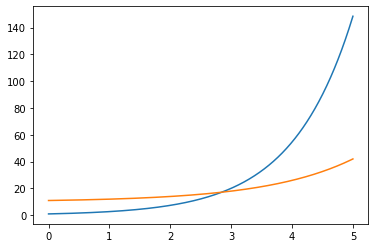

In [33]:
import matplotlib.pyplot as plt
x = np.linspace(0, 5, 1000)
y_exp = np.exp(x)
y_bas2 = 2 ** x + 10
plt.plot(x, y_exp)
plt.plot(x, y_bas2)

In [34]:
y_bas2

array([11.        , 11.00347523, 11.00696254, 11.01046196, 11.01397355,
       11.01749734, 11.02103338, 11.0245817 , 11.02814236, 11.03171539,
       11.03530084, 11.03889875, 11.04250916, 11.04613212, 11.04976767,
       11.05341585, 11.05707671, 11.0607503 , 11.06443665, 11.06813581,
       11.07184783, 11.07557275, 11.07931061, 11.08306146, 11.08682535,
       11.09060232, 11.09439241, 11.09819568, 11.10201216, 11.1058419 ,
       11.10968496, 11.11354137, 11.11741118, 11.12129444, 11.1251912 ,
       11.12910149, 11.13302538, 11.13696291, 11.14091411, 11.14487905,
       11.14885777, 11.15285031, 11.15685673, 11.16087708, 11.16491139,
       11.16895973, 11.17302213, 11.17709865, 11.18118934, 11.18529424,
       11.18941341, 11.1935469 , 11.19769475, 11.20185701, 11.20603374,
       11.21022499, 11.2144308 , 11.21865122, 11.22288631, 11.22713613,
       11.23140071, 11.23568011, 11.23997438, 11.24428357, 11.24860775,
       11.25294694, 11.25730122, 11.26167063, 11.26605523, 11.27